In [1]:
from optimization import *
import optimization
import sys
import importlib
import rotation
importlib.reload(optimization)
sys.path.append("../python")
import parseCouplings
sys.path.append("../Netket")

In [2]:
# Todo: replace this function with actual file reading
def readHamiltonian_params(file, idx, N):
    Jijalphabeta = np.random.rand(3, 3, N, N)
    h = np.random.rand(3, N)

    # Delete 90% of the elements randomly in Jijalphabeta
    mask_J = np.random.rand(3, 3, N, N) < 0.1
    Jijalphabeta = Jijalphabeta * mask_J

    # Delete 90% of the elements randomly in h
    mask_h = np.random.rand(3, N) < 0.1
    h = h * mask_h

    return Jijalphabeta, h


def generate_tfim_params(N, J=1.0, h=1.0):
    """
    Generates Jij and h arrays for the transverse field Ising model (TFIM):
    H = -J sum_{<i,j>} sigma^z_i sigma^z_j - h sum_i sigma^x_i

    Args:
        N (int): Number of spins (1D chain with periodic boundary).
        J (float): Coupling strength.
        h (float): Transverse field strength.

    Returns:
        Jij (np.ndarray): shape (3, 3, N, N), only Jij[2,2,i,j] nonzero for nearest neighbors.
        h (np.ndarray): shape (3, N), only h[0,i] nonzero (x direction).
    """
    Jij = np.zeros((3, 3, N, N))
    for i in range(N):
        j = (i + 1) % N  # periodic boundary
        Jij[2, 2, i, j] = -J
        Jij[2, 2, j, i] = -J  # symmetric

    h_arr = np.zeros((3, N))
    h_arr[0, :] = -h  # transverse field in x direction

    return Jij, h_arr

def TFI2D(g, J=1.0, h=1.0):
    hi = nk.hilbert.Spin(s=0.5, N=g.n_nodes)
    H = -J*sum(nk.operator.spin.sigmaz(hi, i) * nk.operator.spin.sigmaz(hi, j) for( i, j) in g.edges()) 
    H += -h*sum(nk.operator.spin.sigmax(hi,i) for i in g.nodes())

    return H
g = nk.graph.Hypercube(length=4, n_dim=2, pbc=True)

def construct_hamiltonian_bonds_heisenberg(Jijalphabeta, h, bonds):
    # Jijalphabeta = np.array([np.eye(3)*np.max(Jijalphabeta[bond,:,:]) for bond in range(len(bonds))])
    Jijalphabeta = np.array([np.eye(3) for bond in range(len(bonds))])
    return construct_hamiltonian_bonds(Jijalphabeta, h, bonds)


In [3]:
Jij,h,bonds = parseCouplings.parseCouplings("../python/couplings69.csv")

In [4]:
# Jij, h = readHamiltonian_params("hamiltonian_params.txt", 0, 5)
import os
os.chdir("../python")
Jij,h,bonds = parseCouplings.parseCouplings()
# H_ran = construct_hamiltonian_bonds_heisenberg(Jij[10], 0*h[10],  bonds[10])
H_ran = construct_hamiltonian_bonds_rotated(Jij[10], 0*h[10],  bonds[10], 0.1,0.2,0.3)
epsilon = 0.8
H2 = TFI2D(g, 1, 0.5)
H = H_ran
# H = epsilon*H_ran + H2
exact_ground_energy,exact_ground_state = nk.exact.lanczos_ed(H, k = 1, compute_eigenvectors = True)
print("Exact ground state energy:", exact_ground_energy)

Exact ground state energy: [-54.03992906]


In [16]:
np.array(bonds[10]).shape

(32, 2)

In [31]:
g = nk.graph.Hypercube(length=3, n_dim=2, pbc=True)
len(g.edges())

18

In [229]:
print(Jij[10][0:8].shape)
print(h[10][0:4].shape)
print(np.array(bonds[10][0:8]).shape)

(8, 3, 3)
(4, 3)
(8, 2)


In [230]:
filtered_bonds = [bond for bond in bonds[10] if bond[0] < 4 and bond[1] < 4]
filtered_bonds

[(0, 1), (1, 2), (2, 3), (3, 0)]

In [239]:
H_ran_small = construct_hamiltonian_bonds(Jij[10][0:8], 0*h[10][0:4],  filtered_bonds)

In [241]:
H_ran_small_dense = H_ran_small.to_dense()
H_ran_small_dense.shape

(16, 16)

In [242]:
H_ran_small.hilbert.numbers_to_states([0])

Array([[1, 1, 1, 1]], dtype=int8)

In [243]:
x0 = H_ran_small.hilbert.numbers_to_states([0])
x0

Array([[1, 1, 1, 1]], dtype=int8)

In [245]:
x_primes, Hels = H_ran_small.get_conn_flattened(x0, sections=[H_ran_small.hilbert.size])
int(H_ran_small.hilbert.states_to_numbers(x_primes[1]))

4

In [246]:
def ran_walk(startconfig,H,steps = 100):
    N = len(startconfig)
    config = startconfig
    phases = [0]
    configs = [int(H.hilbert.states_to_numbers(config)[0])]
    for i in range(steps):
        x_primes, Hels = H.get_conn_flattened(config, sections=[H.hilbert.size])
        # chosen_idx = np.random.choice(len(x_primes))
        chosen_idx = (i+1) % len(x_primes)
        config = x_primes[chosen_idx]
        phase = np.angle(Hels[chosen_idx]) - phases[i]
        conf_idx = int(H.hilbert.states_to_numbers(config))
        configs.append(conf_idx)
        phases.append(phase)
    return np.array(configs), np.array(phases)
configs, phases = ran_walk(x0,H_ran_small,steps=10)
# e0, psi_0 = nk.exact.lanczos_ed(H_ran_small, k = 1, compute_eigenvectors = True)#
e0, psi_0 = np.linalg.eigh(H_ran_small_dense)
psi_0 = psi_0[:,0]
exact_phases = np.angle(psi_0[configs])

In [247]:
configs

array([ 0,  4, 12,  8, 12, 14, 12, 14, 15, 14,  7])

In [248]:
exact_phases - exact_phases[0]

array([ 0.        ,  1.06125498, -1.04410859,  1.06125498, -1.04410859,
       -0.0078795 , -1.04410859, -0.0078795 , -2.08821717, -0.0078795 ,
       -0.0078795 ])

In [249]:
import numpy as np
from collections import deque

def extract_H_and_theta(H):
    """
    Given complex matrix H[x,x'] = -|H_xx'| * exp(i*(theta[x'] - theta[x])),
    extract |H_xx'| and theta[x], robustly for sparse or disconnected matrices.

    Parameters
    ----------
    H : (N,N) complex ndarray
        Input complex matrix.

    Returns
    -------
    H_abs : (N,N) ndarray
        Magnitude |H_xx'|.
    theta : (N,) ndarray
        Reconstructed phases theta[x] (radians), up to a global shift per connected component.
    components : list[list[int]]
        List of connected components (indices that share nonzero couplings).
    """
    H = np.array(H, dtype=complex)
    N = H.shape[0]
    H_abs = np.abs(H)
    phi = np.angle(-H)  # relative phases (theta[x'] - theta[x])

    # Build adjacency list for nonzero elements
    neighbors = {i: [] for i in range(N)}
    for i in range(N):
        nz = np.nonzero(H_abs[i] > 1e-14)[0]
        for j in nz:
            if i != j:
                neighbors[i].append(j)

    theta = np.full(N, np.nan)
    visited = np.zeros(N, dtype=bool)
    components = []

    for start in range(N):
        if visited[start]:
            continue

        # BFS/DFS over connected component
        queue = deque([start])
        theta[start] = 0.0  # reference phase
        visited[start] = True
        comp = [start]

        while queue:
            i = queue.popleft()
            for j in neighbors[i]:
                if not visited[j]:
                    # Use phase relation: θ[j] = θ[i] + φ_ij
                    theta[j] = (theta[i] + phi[i, j]) % (2*np.pi)
                    visited[j] = True
                    queue.append(j)
                    comp.append(j)
        components.append(comp)

    # Center phases around zero for nicer output
    for comp in components:
        finite = np.isfinite(theta[comp])
        theta[comp] -= np.mean(theta[comp][finite])

    return H_abs, theta, components


In [250]:
H_abs, H_theta, components = extract_H_and_theta(H_ran_small_dense)

In [255]:
np.savetxt("H_ran_small_dense.txt", H_ran_small_dense,delimiter =',')

In [252]:
np.angle(psi_0)

array([ 0.        ,  1.06125498,  1.06125498, -1.04410859,  1.06125498,
        2.09748407, -1.04410859, -0.0078795 ,  1.06125498, -1.04410859,
        2.09748407, -0.0078795 , -1.04410859, -0.0078795 , -0.0078795 ,
       -2.08821717])

In [268]:
import numpy as np
np.set_printoptions(precision=6, suppress=True)

# replace these with your absH and theta if you want to test your data
def check(absH, theta):
    H = -absH * np.exp(1j*(theta[:,None] - theta[None,:]))
    vals, vecs = np.linalg.eigh(-absH)   # eigenpairs of -|H|
    lam = vals[0]                        # lowest eigenvalue
    A = vecs[:,0].copy()
    if np.sum(A) < 0: A *= -1           # fix global sign (optional)
    psi = A * np.exp(1j*theta)
    residual = H.dot(psi) - lam*psi
    print("lambda:", lam)
    print("||H psi - lambda psi||:", np.linalg.norm(residual))
    print("max abs residual:", np.max(np.abs(residual)))
    return lam, A, psi, residual

# Example random test
n = 10
rng = np.random.default_rng(42)
M = rng.random((n,n)); absH = np.abs((M+M.T)/2)
theta = rng.uniform(-2*np.pi, 2*np.pi, size=n)
check(absH, theta)


lambda: -4.973343080956225
||H psi - lambda psi||: 2.7313517226052007e-15
max abs residual: 1.355199909595506e-15


(np.float64(-4.973343080956225),
 array([0.352926, 0.352867, 0.397231, 0.32428 , 0.316156, 0.291838,
        0.311264, 0.248952, 0.227909, 0.303396]),
 array([ 0.144549-0.321966j, -0.28471 +0.208459j, -0.389358-0.078695j,
         0.300256-0.122489j, -0.295745-0.111757j, -0.26694 +0.117952j,
         0.250342-0.184971j, -0.239291-0.068679j,  0.080182+0.213339j,
         0.103139-0.285327j]),
 array([ 0.-0.j,  0.-0.j,  0.+0.j, -0.+0.j,  0.+0.j,  0.-0.j, -0.+0.j,
         0.-0.j, -0.+0.j,  0.-0.j]))

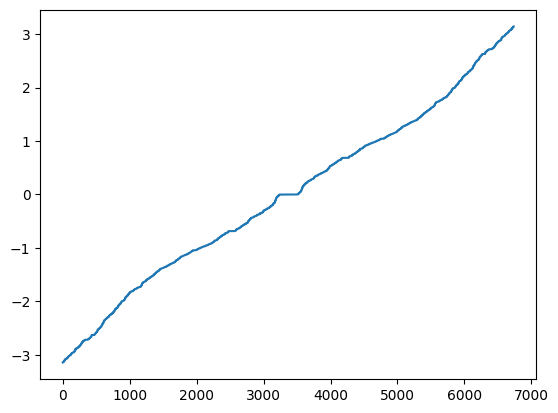

In [209]:
import matplotlib.pyplot as plt

phases = np.exp(1j * np.angle(psi_0))
# Compute the matrix of phase overlaps for all basis states
phases = np.exp(1j * np.angle(psi_0))
matrix_product = np.outer(phases, phases.conj())
plt.plot(np.unique((np.angle(matrix_product * H_ran_small_dense))))


In [95]:
H = TFI2D(g, J=1.0, h=0.5)

In [1]:
moves, coeffs, diagonals = getMoves(H*H*H)

NameError: name 'getMoves' is not defined

In [105]:
diagonals

[('IIII', np.float64(5.0)),
 ('IZIZ', np.float64(4.0)),
 ('ZIZI', np.float64(4.0)),
 ('ZZZZ', np.float64(4.0))]

In [91]:
coeffs[0:3]

array([-1.70650018+0.j,  0.79122579+0.j, -0.8525139 +0.j])

In [89]:
H.to_pauli_strings().__dict__["_operators"]

array(['XIIIXIIIIIIIIIII', 'XIIIYIIIIIIIIIII', 'XIIIZIIIIIIIIIII',
       'YIIIXIIIIIIIIIII', 'YIIIYIIIIIIIIIII', 'YIIIZIIIIIIIIIII',
       'ZIIIXIIIIIIIIIII', 'ZIIIYIIIIIIIIIII', 'ZIIIZIIIIIIIIIII',
       'IXIIIXIIIIIIIIII', 'IXIIIYIIIIIIIIII', 'IXIIIZIIIIIIIIII',
       'IYIIIXIIIIIIIIII', 'IYIIIYIIIIIIIIII', 'IYIIIZIIIIIIIIII',
       'IZIIIXIIIIIIIIII', 'IZIIIYIIIIIIIIII', 'IZIIIZIIIIIIIIII',
       'IIXIIIXIIIIIIIII', 'IIXIIIYIIIIIIIII', 'IIXIIIZIIIIIIIII',
       'IIYIIIXIIIIIIIII', 'IIYIIIYIIIIIIIII', 'IIYIIIZIIIIIIIII',
       'IIZIIIXIIIIIIIII', 'IIZIIIYIIIIIIIII', 'IIZIIIZIIIIIIIII',
       'IIIXIIIXIIIIIIII', 'IIIXIIIYIIIIIIII', 'IIIXIIIZIIIIIIII',
       'IIIYIIIXIIIIIIII', 'IIIYIIIYIIIIIIII', 'IIIYIIIZIIIIIIII',
       'IIIZIIIXIIIIIIII', 'IIIZIIIYIIIIIIII', 'IIIZIIIZIIIIIIII',
       'IIIIXIIIXIIIIIII', 'IIIIXIIIYIIIIIII', 'IIIIXIIIZIIIIIII',
       'IIIIYIIIXIIIIIII', 'IIIIYIIIYIIIIIII', 'IIIIYIIIZIIIIIII',
       'IIIIZIIIXIIIIIII', 'IIIIZIIIYIIIIIII', 'IIIIZIIIZIIIII

In [ ]:
importlib.reload(optimization)

<module 'optimization' from '/net/storage/niggeni/Documents/Projects/DataMiningRBMs/python/../Netket/optimization.py'>

In [40]:
Jij_hash = hash(Jij.tobytes())
h_hash = hash(h.tobytes())

params = generate_params(
    alpha=30,
    seed=1234,
    learning_rate=3e-3,
    n_iter=100,
    show_progress=True,
    out="data/rbm_optimization_test_symm",
    symmetries = g.automorphisms(),
    H_hash = hash(H),
    diag_shift=0.5,
    # Jij_hash=Jij_hash,
    # h_hash=h_hash,
)

# out = optimize_rbm(H, params)


In [14]:
params2 = generate_params(
    alpha=1,
    seed=1234,
    learning_rate=3e-2,
    n_iter=10,
    show_progress=True,
    out="data/rbm_optimization_test_2",
    # symmetries = g.automorphisms(),
    epsilon = epsilon,
    diag_shift=8e-3,
    # Jij_hash=Jij_hash,
    # h_hash=h_hash,
)

out2 = optimize_rbm(H, params2)

  0%|          | 0/10 [00:00<?, ?it/s]

In [41]:
out2.expect(H)

-5.296e+01+5.898e-17j [σ²=9.6e+00]

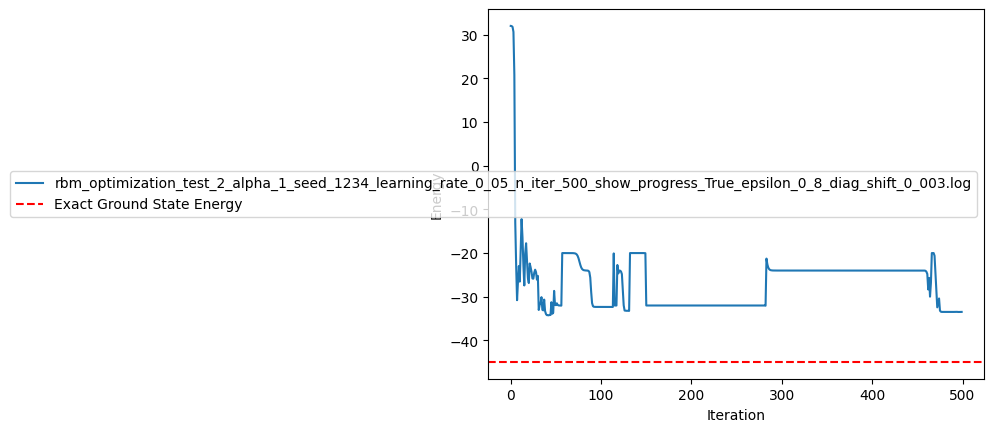

In [44]:
import json
import os
import matplotlib.pyplot as plt
log_files = [os.path.join("data", f) for f in os.listdir("data") if f.endswith(".log")]

fig, ax = plt.subplots()

# Extract the common prefix from all log file names

for log_file in log_files:
    with open(log_file) as f:
        data_rbm = json.load(f)
    iters = data_rbm["Energy"]["iters"]
    energy = data_rbm["Energy"]["Mean"]["real"]
    # Use the substring that differs from the common prefix as the label
    label = os.path.basename(log_file)
    ax.plot(iters, energy, label=label)

ax.set_xlabel("Iteration")
ax.set_ylabel("Energy")
plt.axhline(y=exact_ground_energy, color='r', linestyle='--', label='Exact Ground State Energy')
ax.legend()
plt.show()


In [ ]:
import analysis
analysis.read_h5_attributes(params2["out"] + ".h5")

{'alpha': np.int64(1),
 'epsilon': np.float64(0.1),
 'learning_rate': np.float64(0.003),
 'n_iter': np.int64(400),
 'out': 'data/rbm_optimization_test_2_alpha_1_seed_1234_learning_rate_0_003_n_iter_400_show_progress_True_symmetric_False_epsilon_0_1',
 'seed': np.int64(1234),
 'show_progress': np.True_,
 'symmetric': np.False_}

In [ ]:
write_output(H, out2, params2)

Could not read log file data/rbm_optimization_test_2_alpha_48_seed_1234_learning_rate_0_003_n_iter_400_show_progress_True_epsilon_0_8_diag_shift_0_01.log: [Errno 2] No such file or directory: 'data/rbm_optimization_test_2_alpha_48_seed_1234_learning_rate_0_003_n_iter_400_show_progress_True_epsilon_0_8_diag_shift_0_01.log'
Flipping the sign of the ground state wavefunction to ensure positive overlap.


In [40]:
params = generate_params(
    alpha=1,
    seed=1234,
    learning_rate=8e-3,
    n_iter=300,
    show_progress=True,
    rot_alpha= 0,
    rot_beta=0.5*np.pi,
    rot_gamma=0.6241423,
    out=f"../data/data_rotated/rbm_optimization",
)
params["out"]

'../data/data_rotated/rbm_optimization_alpha_1_seed_1234_learning_rate_0_008_n_iter_300_show_progress_True_rot_alpha_0_rot_beta_1_5707963267948966_rot_gamma_0_6241423'

In [43]:
Jij,h,bonds = parseCouplings.parseCouplings("../python/couplings69.csv")
angle_range = np.linspace(0, 0.5*np.pi, 2)

for alpha in angle_range:
    for beta in angle_range:
        for gamma in angle_range:
            H = construct_hamiltonian_bonds_rotated(Jij[50], h[50],  bonds[50], alpha, beta, gamma)
            exact_ground_energy,exact_ground_state = nk.exact.lanczos_ed(H, k = 1, compute_eigenvectors = True)

            print(f"Angles: ({alpha:.2f}, {beta:.2f}, {gamma:.2f}), Hamiltonian: Exact ground state energy: {exact_ground_energy[0]}")

            params = generate_params(
                alpha=1,
                seed=1234,
                learning_rate=8e-3,
                n_iter=400,
                show_progress=True,
                rot_alpha=alpha,
                rot_beta=beta,
                rot_gamma=gamma,
                out=f"../data/data_rotated/rbm_optimization",
            )
            out = optimize_rbm(H, params)
            
            write_output(H, out, params)

Angles: (0.00, 0.00, 0.00), Hamiltonian: Exact ground state energy: -54.26621412990654


  0%|          | 0/400 [00:00<?, ?it/s]

Angles: (0.00, 0.00, 1.57), Hamiltonian: Exact ground state energy: -54.266214129906736


  0%|          | 0/400 [00:00<?, ?it/s]

Angles: (0.00, 1.57, 0.00), Hamiltonian: Exact ground state energy: -54.266214129906736


  0%|          | 0/400 [00:00<?, ?it/s]

Angles: (0.00, 1.57, 1.57), Hamiltonian: Exact ground state energy: -54.266214129906594


  0%|          | 0/400 [00:00<?, ?it/s]

Angles: (1.57, 0.00, 0.00), Hamiltonian: Exact ground state energy: -54.266214129906764


  0%|          | 0/400 [00:00<?, ?it/s]

Angles: (1.57, 0.00, 1.57), Hamiltonian: Exact ground state energy: -54.26621412990656


  0%|          | 0/400 [00:00<?, ?it/s]

Angles: (1.57, 1.57, 0.00), Hamiltonian: Exact ground state energy: -54.266214129906736


  0%|          | 0/400 [00:00<?, ?it/s]

Angles: (1.57, 1.57, 1.57), Hamiltonian: Exact ground state energy: -54.266214129906835


  0%|          | 0/400 [00:00<?, ?it/s]

In [5]:
import os

# h5_files = [os.path.join("data_rand", f) for f in os.listdir('data_rand') if f.endswith('.h5')]
h5_files = [os.path.join("../data/data_rotated", f) for f in os.listdir('../data/data_rotated') if f.endswith('.h5')]
print(h5_files)

['../data/data_rotated/rbm_optimization_alpha_1_seed_1234_learning_rate_0_008_n_iter_400_show_progress_False_rot_alpha_0_3693876085377084_rot_beta_0_764288275501484_rot_gamma_1_531411503936541.h5', '../data/data_rotated/rbm_optimization_alpha_1_seed_1234_learning_rate_0_008_n_iter_400_show_progress_False_rot_alpha_0_44459293368815256_rot_beta_0_008973149430378965_rot_gamma_0_4593948646110098.h5', '../data/data_rotated/rbm_optimization_alpha_1_seed_1234_learning_rate_0_008_n_iter_400_show_progress_False_rot_alpha_0_36456339480663824_rot_beta_1_3272476633202974_rot_gamma_0_976046924083371.h5', '../data/data_rotated/rbm_optimization_alpha_1_seed_1234_learning_rate_0_008_n_iter_400_show_progress_False_rot_alpha_1_025806591604705_rot_beta_0_6636879804448029_rot_gamma_0_40389680946782824.h5', '../data/data_rotated/rbm_optimization_alpha_1_seed_1234_learning_rate_0_008_n_iter_400_show_progress_False_rot_alpha_0_8636729976004734_rot_beta_0_894598848776103_rot_gamma_0_1542775870366362.h5', '../

In [6]:
from analysis import *
load_outputs_to_dataframe(h5_files)

,psi,psi_0,Delta_E,infidelity
0,"[(-0.0009071705+0.00031600223j), (0.0003175422...",[(-0.0011822779292414843+0.0006514321570310087...,0.103743,0.990176
1,"[(-1.0200166e-05+9.107927e-06j), (8.151106e-06...",[(-1.808286313931901e-07+3.2005616770418713e-0...,0.123186,0.999948
2,"[(0.001995487-0.023808798j), (-0.005822409+0.0...","[(0.007111324009398755-0.023676767848941994j),...",0.000733,0.002392
3,"[(0.0041645826-0.006317043j), (-0.00053992827+...",[(-0.007333034090437174-2.849224019744056e-05j...,0.000531,0.001442
4,"[(0.007687317+0.0068763364j), (-0.007626226+0....","[(0.010362418637859106+0.003490020874530769j),...",0.001576,0.004966
5,"[(-0.020315237+0.02570005j), (0.013498547-0.01...","[(0.022037945842076318-0.029903528534419344j),...",0.067546,0.697001
6,"[(-2.9715607e-06-1.18197946e-07j), (2.1757134e...",[(-0.00047126691192422637+0.000426507344858401...,0.122952,0.999761
7,"[(-5.344648e-07-2.282598e-05j), (1.6885562e-05...",[(-1.2387411686823587e-06+1.0086708220736559e-...,0.119888,0.998356
8,"[(0.007199597+0.0066867205j), (-0.00829119+0.0...",[(0.008502770886371745+0.0039914278156320095j)...,0.000494,0.001289
9,"[(0.011822619+0.0041554035j), (-0.00958271-0.0...","[(0.0018785822392949068+0.01273557525003682j),...",0.003552,0.025589


In [22]:
import optuna
def objective(trial):
    # Suggest values for alpha, beta, gamma in [0, 0.5*np.pi]
    alpha = trial.suggest_float('alpha', 0, 0.5*np.pi)
    beta = trial.suggest_float('beta', 0, 0.5*np.pi)
    gamma = trial.suggest_float('gamma', 0, 0.5*np.pi)
    
    # Construct Hamiltonian with suggested angles
    H = construct_hamiltonian_bonds_rotated(Jij[50], h[50], bonds[50], alpha, beta, gamma)
    
    params = generate_params(
        alpha=1,
        seed=1234,
        learning_rate=8e-3,
        n_iter=400,
        show_progress=False,
        rot_alpha=alpha,
        rot_beta=beta,
        rot_gamma=gamma,
        out=f"../data/data_rotated/rbm_optimization",
    )
    out = optimize_rbm(H, params)
    write_output(H, out, params)
    en = out.expect(H).real().mean
    return en

study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=30)

print("Best angles found:")
print("alpha =", study.best_params['alpha'])
print("beta =", study.best_params['beta'])
print("gamma =", study.best_params['gamma'])
print("Minimum ground state energy =", study.best_value)

[I 2025-09-29 18:58:44,397] A new study created in memory with name: no-name-09990567-cc5e-402a-99bb-d46990878aac
[I 2025-09-29 18:59:41,094] Trial 0 finished with value: -47.61823726144692 and parameters: {'alpha': 0.992825121449861, 'beta': 0.28184134120550663, 'gamma': 1.1704005709525558}. Best is trial 0 with value: -47.61823726144692.
[I 2025-09-29 19:00:54,298] Trial 1 finished with value: -47.58141012177944 and parameters: {'alpha': 0.44459293368815256, 'beta': 0.008973149430378965, 'gamma': 0.4593948646110098}. Best is trial 0 with value: -47.61823726144692.
[I 2025-09-29 19:01:58,033] Trial 2 finished with value: -47.766371041298314 and parameters: {'alpha': 0.1148616042331309, 'beta': 0.216217833955141, 'gamma': 1.4334885673588642}. Best is trial 2 with value: -47.766371041298314.
[I 2025-09-29 19:03:12,716] Trial 3 finished with value: -54.23380740311619 and parameters: {'alpha': 0.15770960222919114, 'beta': 1.4469284030393488, 'gamma': 0.7115125625756978}. Best is trial 3 w

Best angles found:
alpha = 0.18610694312202125
beta = 1.4130236875883821
gamma = 1.4413482562269746
Minimum ground state energy = -54.24264712903329


In [9]:
# os.chdir("Netket")
import importlib
import analysis
importlib.reload(analysis)

<module 'analysis' from '/net/storage/niggeni/Documents/Projects/DataMiningRBMs/python/../Netket/analysis.py'>

In [29]:
hypotheses = {
    "std_phase" : std_phase,
    "IPR" : ipr,
    "SPCA" : pca_entropy,
    "Renyi_2" : renyi_entropy,
}
df = load_outputs_to_dataframe(h5_files)
df = attach_hypotheses_fields(df, hypotheses)
df["rot_alpha"] = np.array([analysis.read_h5_attributes(f)["rot_alpha"] for f in h5_files])
df["rot_beta"] = np.array([analysis.read_h5_attributes(f)["rot_beta"] for f in h5_files])
df["rot_gamma"] = np.array([analysis.read_h5_attributes(f)["rot_gamma"] for f in h5_files])

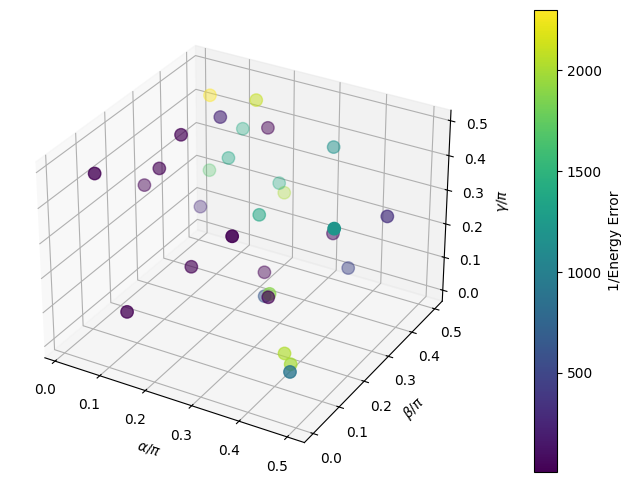

In [11]:
from mpl_toolkits.mplot3d import Axes3D

import matplotlib.pyplot as plt

# Extract rotation angles and energy error
energy_error = 1/df["Delta_E"]

fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111, projection='3d')
sc = ax.scatter(df["rot_alpha"]/np.pi, df["rot_beta"]/np.pi, df["rot_gamma"]/np.pi, c=energy_error, cmap='viridis', s=80)
ax.set_xlabel(r"$\alpha/\pi$")
ax.set_ylabel(r"$\beta/\pi$")
ax.set_zlabel(r"$\gamma/\pi$")
plt.colorbar(sc, label="1/Energy Error", pad=0.1)
plt.show()

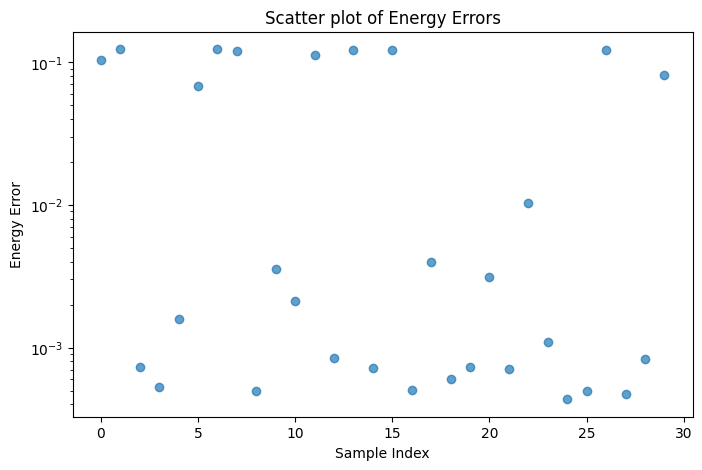

In [24]:
import matplotlib.pyplot as plt

# Assuming df["Delta_E"] contains arrays, extract the first element for each entry
energies = df["Delta_E"]

plt.figure(figsize=(8, 5))
plt.scatter(range(len(energies)), energies, alpha=0.7)
plt.xlabel("Sample Index")
plt.ylabel("Energy Error")
plt.yscale("log")
plt.title("Scatter plot of Energy Errors")
plt.show()

In [32]:
Jij[50][0,:,:]

array([[-0.41859285,  0.63976083, -1.5100352 ],
       [ 0.83865364,  0.86525379,  0.50709675],
       [-0.44708352,  0.8977601 ,  0.16044521]])

Jij[50] before rotation:
 [[-0.31733708  0.61595921  0.54596863]
 [-0.62777364 -0.18191422  0.08496754]
 [-0.07472594  0.23461322 -2.28606964]]
h[50] before rotation:
 [-0.17039252  0.10899523  0.70310945]

Optimal rotation angles: alpha=0.18610694312202125, beta=1.4130236875883821, gamma=1.4413482562269746
Jij[50] after optimal rotation:
 [[-0.47323043 -0.56003959 -0.67266319]
 [-0.88182107 -1.87784598  0.00253944]
 [ 0.28007585 -0.96868247 -0.43424453]]
h[50] after optimal rotation:
 [0.10999631 0.66691242 0.28000911]


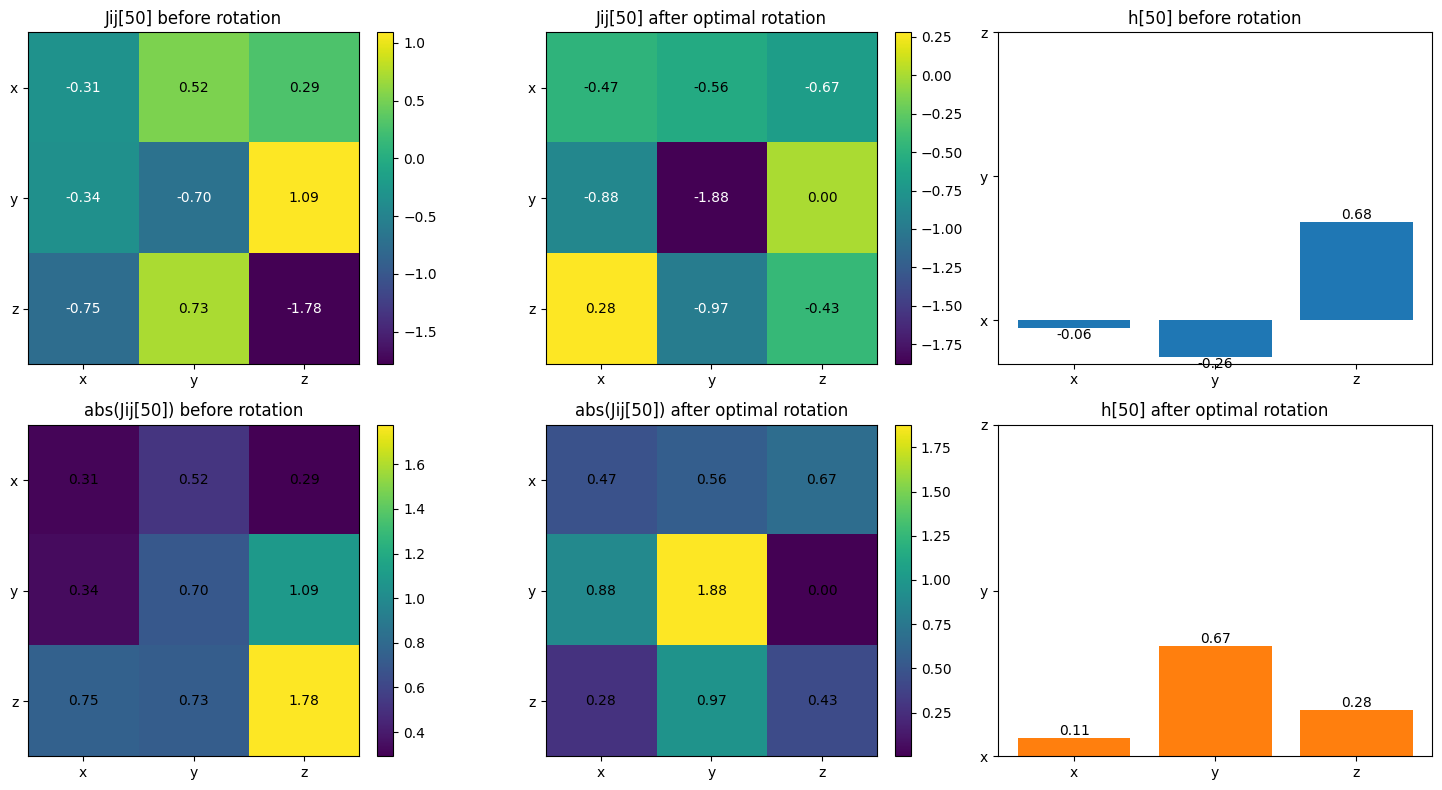

In [38]:
print("IPR of the best rotation (min Delta_E):", df["IPR"][min_idx])
print("delta E of the best rotation (min Delta_E):", df["Delta_E"][min_idx])

print("IPR of the worst rotation (max Delta_E):", df["IPR"][max_idx])
print("delta E of the worst rotation (max Delta_E):", df["Delta_E"][max_idx])

IPR of the best rotation (min Delta_E): 3.655221481174877e-05
delta E of the best rotation (min Delta_E): 0.00043463943277260205
IPR of the worst rotation (max Delta_E): 0.007731874773239227
delta E of the worst rotation (max Delta_E): 0.12318612179702386


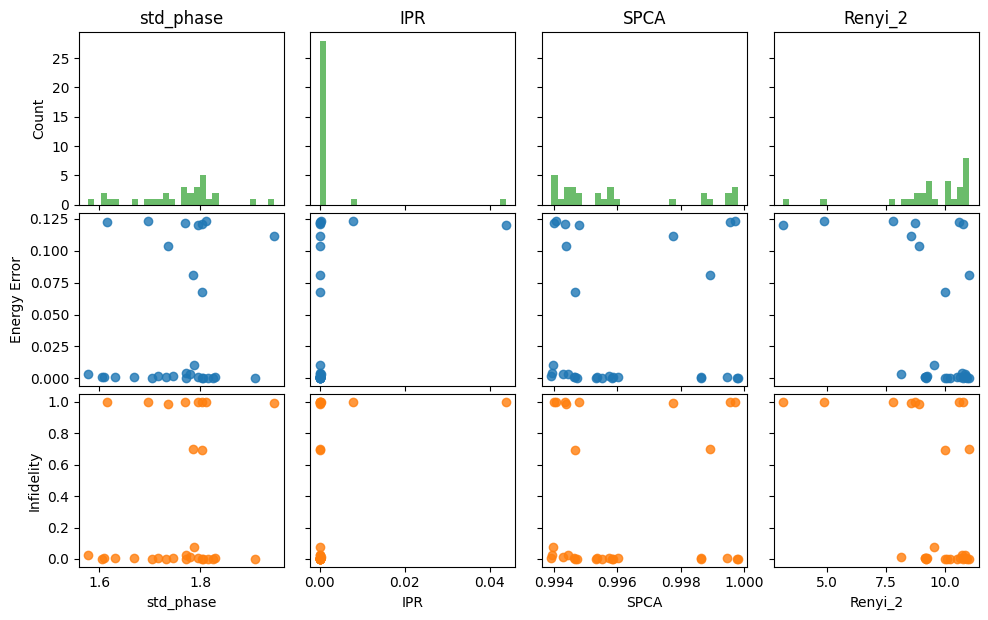

In [30]:
import matplotlib.pyplot as plt
N = len(hypotheses)
fig, axes = plt.subplots(3, N, figsize=(0.6*4*N, 0.6*10), sharey='row', sharex='col')

for idx, name in enumerate(hypotheses.keys()):
    # First row: Histogram of hypothesis values
    axes[0, idx].hist(df[name], bins=30, color="C2", alpha=0.7)
    axes[0, idx].set_title(f"{name}")
    if idx == 0:
        axes[0, 0].set_ylabel("Count")

    # Second row: Energy error vs hypothesis
    axes[1, idx].scatter(df[name], df["Delta_E"], color="C0", alpha=0.8)
    if idx == 0:
        axes[1, 0].set_ylabel("Energy Error")

    # Third row: Infidelity vs hypothesis
    infid = df.apply(lambda row: infidelity(row["psi"], row["psi_0"]), axis=1)
    axes[2, idx].scatter(df[name], infid, color="C1", alpha=0.8)
    axes[2, idx].set_xlabel(name)
    if idx == 0:
        axes[2, 0].set_ylabel("Infidelity")

plt.tight_layout(pad=0, h_pad=0, w_pad=0)
plt.show()


In [ ]:
plt.figure(figsize=(6, 4))
plt.scatter(df["Delta_E"], infid, alpha=0.7)
plt.xlabel("Energy Error")
plt.ylabel("Infidelity")
plt.show()